<a href="https://colab.research.google.com/github/LNhart/automl_metalearning/blob/main/xgboost_metalearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas==1.3.5
!pip install xgboost==1.5.1
!pip install openml==0.12.2
!pip install seaborn==0.12.2

In [ ]:
!pip list

utility functions

In [2]:
import os
import openml
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

test_ids = [
    16, 22, 31, 2074, 2079, 3493, 3907, 3913, 9950, 9952, 9971, 10106, 14954, 14970, 146212,
    146825, 167119, 167125, 168332, 168336
]

meta_feature_names = [
    "data_id", "name", "status", "MajorityClassSize", "MaxNominalAttDistinctValues",
    "MinorityClassSize", "NumberOfClasses", "NumberOfFeatures", "NumberOfInstances",
    "NumberOfInstancesWithMissingValues", "NumberOfMissingValues", "NumberOfNumericFeatures",
    "NumberOfSymbolicFeatures"
]

default_config = {
    "n_estimators": 464,  # num_rounds
    "eta": 0.0082,
    "subsample": 0.982,
    "max_depth": 11,
    "min_child_weight": 3.30,
    "colsample_bytree": 0.975,
    "colsample_bylevel": 0.9,
    "lambda": 0.06068,
    "alpha": 0.00235,
    "gamma": 0
}

use_gpu = True
silent = True

def get_hyperparameter_list() -> List[str]:
    return list(default_config.keys())

def get_hyperparameter_data_list() -> List[str]:
    config_list = get_hyperparameter_list()
    config_list.remove("n_estimators")
    config_list.append("num_round")
    return config_list

def get_metafeature_list() -> List[str]:
    return meta_feature_names

def load_data_from_path(path_to_files: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Loads the meta files from disk and returns them as data frames"""
    files_to_load = dict(
        features="features.csv",
        meta_features="xgboost_meta_data.csv"
    )
    meta_features = pd.read_csv(os.path.join(path_to_files, files_to_load["features"]))
    meta_data = pd.read_csv(os.path.join(path_to_files, files_to_load["meta_features"]))
    return meta_features, meta_data

def _get_preprocessor(categoricals, continuous):
    """Preprocessing"""
    preprocessor = make_pipeline(
        ColumnTransformer([
            (
                "cat",
                make_pipeline(
                    SimpleImputer(strategy="most_frequent"),
                    OneHotEncoder(handle_unknown="ignore")
                ),
                categoricals.tolist(),
            ),
            (
                "cont",
                make_pipeline(
                    SimpleImputer(strategy="median")
                ),
                continuous.tolist(),
            )
        ])
    )
    return preprocessor

def get_task_metafeatures(task_id: int, meta_feature_names: List[str]) -> Dict:
    """Get meta features from an OpenML task based on its task id"""
    task = openml.tasks.get_task(task_id)
    features = openml.datasets.list_datasets(data_id=[task.dataset_id])[task.dataset_id]
    features["data_id"] = features["did"]

    for feature in set(features.keys()) - set(meta_feature_names):
        features.pop(feature)

    return features

def _convert_labels(labels):
    """Converts boolean labels (if exists) to strings"""
    label_types = list(map(lambda x: isinstance(x, bool), labels))
    if np.all(label_types):
        _labels = list(map(lambda x: str(x), labels))
        if isinstance(labels, pd.Series):
            labels = pd.Series(_labels, index=labels.index)
        elif isinstance(labels, np.array):
            labels = np.array(labels)
    return labels

def load_test_data(task_id: int) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Fetches data from OpenML, converts data types, to yield train-test numpy arrays"""
    task = openml.tasks.get_task(task_id, download_data=False)
    nclasses = len(task.class_labels)
    dataset = openml.datasets.get_dataset(task.dataset_id, download_data=False)
    X, y, categorical_ind, feature_names = dataset.get_data(target=task.target_name, dataset_format="dataframe")

    categorical_ind = np.array(categorical_ind)
    (cat_idx,) = np.where(categorical_ind)
    (cont_idx,) = np.where(~categorical_ind)

    # splitting dataset into train and test (10% test)
    # train-test split is fixed for a task and its associated dataset (from OpenML)
    train_idx, test_idx = task.get_train_test_split_indices()  # we only use the first of the 10 CV folds

    train_x = X.iloc[train_idx]
    train_y = y.iloc[train_idx]
    test_x = X.iloc[test_idx]
    test_y = y.iloc[test_idx]

    preprocessor = _get_preprocessor(cat_idx, cont_idx)

    # preprocessor fit only on the training set
    train_x = preprocessor.fit_transform(train_x)
    test_x = preprocessor.transform(test_x)

    # converting bool labels
    train_y = _convert_labels(train_y)
    test_y = _convert_labels(test_y)

    # encoding labels
    le = LabelEncoder()
    le.fit(np.unique(train_y))
    train_y = le.transform(train_y)
    test_y = le.transform(test_y)

    return train_x, train_y, test_x, test_y, nclasses


baseline

In [42]:
import time
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score

#from utils import get_task_metafeatures, load_test_data, meta_feature_names, \
#    default_config, test_ids

class XGBoostTest:
    """Set seed, get train-test data and meta features of task_id"""
    def __init__(self, task_id: int, meta_feature_names: list, seed: int = 12345):
        self.seed = seed
        self.task_id = task_id
        self.train_x, self.train_y, self.test_x, self.test_y, self.nclasses = load_test_data(task_id)
        self.meta_features = get_task_metafeatures(task_id, meta_feature_names)

    """Initialize the xgboost learner based on a hyperparameter configuration"""
    def init_model(self, config: dict, seed: int = None):
        rng = np.random.RandomState(self.seed) if seed is None else np.random.RandomState(seed)
        extra_args = dict(random_state=rng, eval_metric=roc_auc_score)
        if self.nclasses > 2:
            extra_args["objective"] = "multi:softprob"
            extra_args.update({"num_class": self.nclasses})

        if use_gpu:
          config = config.copy()
          config["tree_method"] = "gpu_hist"

        if silent:
          config = config.copy()
          config["verbosity"] = 0

        #print(default_config)
        #print(config)

        model = xgb.XGBClassifier(
            **config,
            **extra_args
        )
        return model

    """
    Evaluate the xbgoost learner by first initializing the model based on a hyperparameter configuration,
    train on train set and evaluate on test set based on AUC
    """
    def evaluate(self, config: dict, seed: int=None):
        model = self.init_model(config, seed)
        train_start = time.time()
        model.fit(self.train_x, self.train_y)
        timetrain = time.time() - train_start
        prediction_prob = model.predict_proba(self.test_x)
        if self.nclasses == 2:
            # handling binary classification
            prediction_prob = prediction_prob[:, 1]
        auc = roc_auc_score(self.test_y, prediction_prob, multi_class="ovr")
        return auc, timetrain

Loading the data

In [4]:
# in this case, datasets were put into my google drive in a folder called "xgboost--metalearning"

tasks_meta, configs_meta = load_data_from_path("/content/drive/MyDrive/xgboost--metalearning")

Estimating importance of hyperparameters

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

def feature_importance_mdi(data_id: int, cols: List[str]):
  '''calculates feature importance based on random forest'''
  config_meta_task = configs_meta[configs_meta["data_id"] == data_id]
  X = config_meta_task[cols]
  y = config_meta_task["auc"]

  rfr = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=0)
  rfr.fit(X, y)
  feature_importances = rfr.feature_importances_

  return feature_importances

def feature_importance_lr_coef(data_id: int, cols: List[str]):
  '''calculates feature importance based on coeficients in linear regression model'''
  config_meta_task = configs_meta[configs_meta["data_id"] == data_id]
  X = config_meta_task[cols]
  y = config_meta_task["auc"]

  scaler = StandardScaler()
  X = scaler.fit_transform(X)
  lr = LinearRegression()
  lr.fit(X, y)
  feature_coefs = lr.coef_
  
  return feature_coefs

cols = get_hyperparameter_list()
cols.remove("n_estimators")
cols.append("num_round")

data_ids = configs_meta["data_id"].unique()
results_mdi = [feature_importance_mdi(id, cols) for id in data_ids]
results_rc = [feature_importance_lr_coef(id, cols) for id in data_ids]

<Axes: xlabel='variable', ylabel='value'>

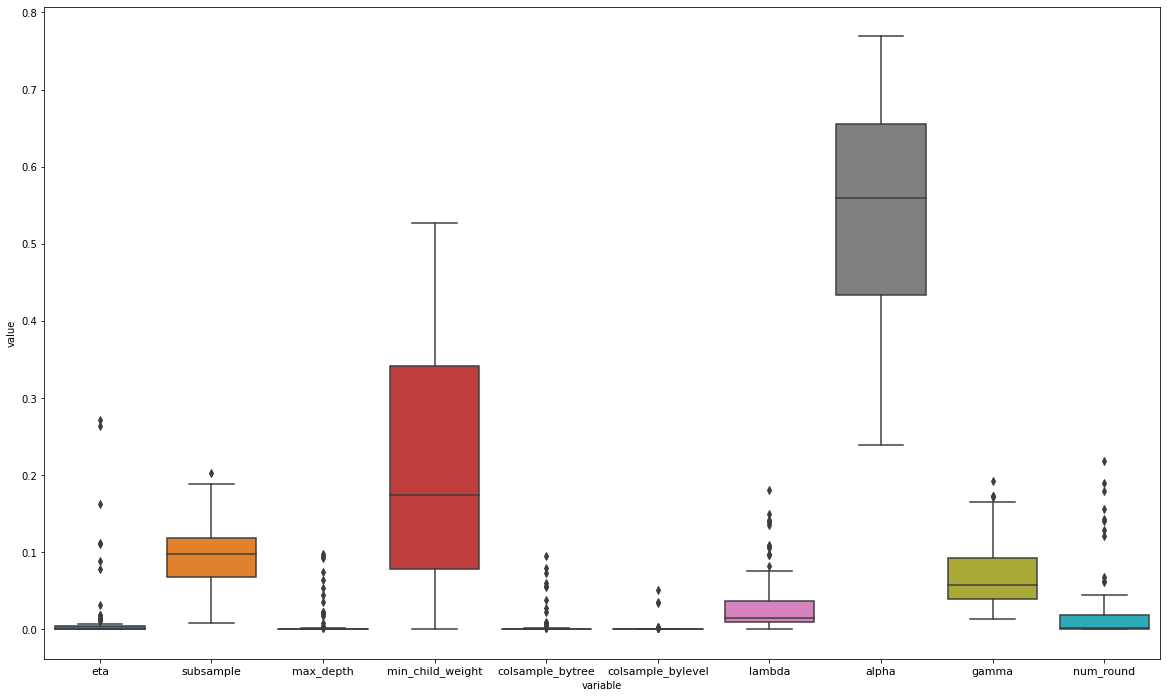

In [74]:
from seaborn import boxplot
import matplotlib.pyplot as plt

f_mdi = pd.DataFrame(data=results_mdi, columns=cols, index = data_ids)

plt.figure(figsize=(20, 12))
plt.xticks(fontsize=11)

boxplot(data=pd.melt(df_mdi), x="variable", y="value")

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

cols = get_hyperparameter_list()
cols.remove("n_estimators")
cols.append("num_round")

# standardizing the data
configs_meta_standardized = pd.DataFrame(data=scaler.fit_transform(configs_meta[cols]), columns=cols)

configs_meta_standardized["data_id"] = configs_meta["data_id"]
configs_meta_standardized["auc"] = configs_meta["auc"]

# getting the top config for each group
configs_top = configs_meta_standardized.sort_values(by=["data_id", "auc"], 
                                                    ascending=[True, False]).groupby("data_id").nth(1)

configs_top = configs_top.drop(columns=["auc"])

<Axes: xlabel='variable', ylabel='value'>

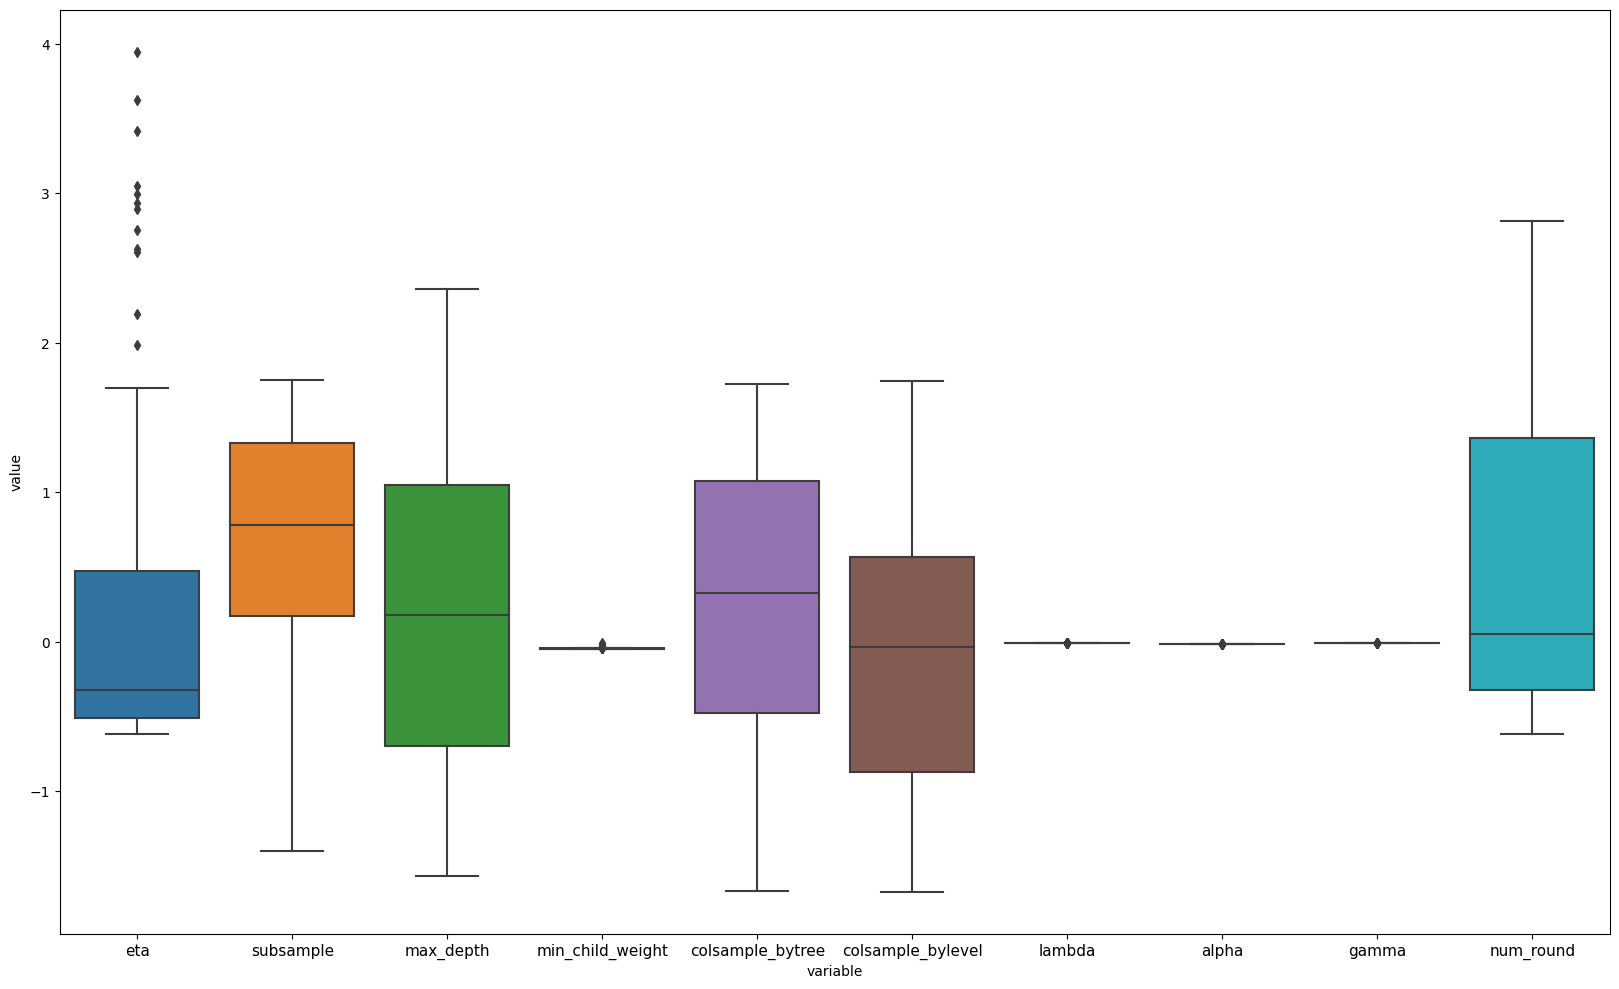

In [10]:
from seaborn import boxplot
import matplotlib.pyplot as plt

#plot of the variance in top values for given hyperparameters
plt.figure(figsize=(20, 12))
plt.xticks(fontsize=11)

boxplot(data=pd.melt(configs_top), x="variable", y="value")

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# only clustering based on these hyperparams
relevant_hyperparams = ["num_round", "eta", "subsample", "max_depth", "min_child_weight", "colsample_bytree"]

hyperparams = configs_meta[relevant_hyperparams]
hyperparams = StandardScaler().fit_transform(hyperparams)

df_clustering_configs = pd.DataFrame(hyperparams, columns=relevant_hyperparams)
df_clustering_configs["data_id"] = configs_meta["data_id"]
df_clustering_configs["auc"] = configs_meta["auc"]

# selecting top 20 configs per task
df_clustering_configs_top20 =  df_clustering_configs.sort_values(by=["data_id", "auc"], 
                                                    ascending=[True, False]).groupby("data_id").head(20)
df_clustering_configs_top20 = df_clustering_configs_top20.drop(columns=["data_id", "auc"])
df_clustering_configs_top20 = df_clustering_configs_top20.drop_duplicates()

# clustering into 25 clusters
kmeans = KMeans(n_clusters=25, random_state=0, init="k-means++").fit(df_clustering_configs_top20)
df_clustering_configs_top20["cluster"] = kmeans.labels_

df_clustering_configs_top20

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,num_round,eta,subsample,max_depth,min_child_weight,colsample_bytree,cluster
1584222,2.419637,2.226816,-0.602792,-0.913329,-0.046683,-0.500052,22
1584271,-0.261079,0.917630,0.846709,1.268339,-0.047239,1.214615,2
1584809,-0.105601,-0.596334,1.738073,1.486505,-0.047367,1.372577,2
1584892,0.881941,3.788776,0.586777,0.177505,-0.048494,1.683623,18
1584908,0.101134,-0.152861,1.520750,1.486505,-0.046305,-0.636191,9
...,...,...,...,...,...,...,...
1373503,1.191189,-0.438611,0.907455,0.613838,-0.016473,-0.437212,13
1227744,-0.303792,-0.378343,-0.236468,-0.695162,-0.040970,-0.030301,5
1247584,-0.449019,1.698016,0.141722,0.177505,-0.030698,1.639710,11
1233050,-0.500276,-0.447740,0.889890,1.268339,-0.040242,0.749812,2


In [30]:
def generate_candidate_configs_median(clusters: pd.Series, config_meta: pd.DataFrame):
  ''' creates one candidate per cluster with median config values within each cluster'''
  config_meta["cluster"] = clusters
  candidates = config_meta.groupby("cluster").median()
  candidates = candidates.drop(columns=["data_id", "repl", "timetrain", "auc", "task_id"])
  candidates["num_round"] = candidates["num_round"].astype(int)
  candidates["max_depth"] = candidates["max_depth"].astype(int)
  return candidates

median_candidates = generate_candidate_configs_median(df_clustering_configs_top20["cluster"], configs_meta)

# writes candidates to csv to allow loading them without rerunning prior steps
median_candidates.to_csv("candidates.csv", index_label="cluster")

In [7]:
median_candidates

,num_round,eta,gamma,lambda,alpha,subsample,max_depth,min_child_weight,colsample_bytree,colsample_bylevel
cluster,,,,,,,,,,
0.0,166.0,0.071020,0.022067,0.135410,0.053157,0.413686,9.0,2.542185,0.282563,0.649248
1.0,1392.5,0.034815,0.002679,0.152595,0.046335,0.602411,4.0,3.168880,0.838539,0.568505
2.0,173.0,0.041437,0.026897,0.197935,0.038136,0.826596,14.0,2.450420,0.760872,0.557491
3.0,289.0,0.466464,0.001009,0.207158,0.035647,0.370796,13.0,4.599500,0.891617,0.489028
4.0,165.0,0.739480,0.011468,0.538858,0.215100,0.723950,3.0,2.729570,0.700514,0.514345
5.0,104.5,0.049899,0.013476,0.049453,0.101912,0.422882,4.0,2.479170,0.624448,0.519975
6.0,2971.0,0.054328,0.003280,0.328136,0.031793,0.757398,7.0,12.217100,0.655027,0.523727
7.0,389.0,0.024508,0.005148,0.139992,0.070846,0.561667,13.0,3.000490,0.657172,0.465027
8.0,1552.0,0.022405,0.000917,1.590720,0.096197,0.625077,14.0,3.343410,0.266350,0.500222


Creating upper and lower bounds

In [10]:
candidates_lower = median_candidates.min()
candidates_upper = median_candidates.max()
top_20_lower = configs_meta.loc[df_clustering_configs_top20.index].quantile(0.025)
top_20_upper = configs_meta.loc[df_clustering_configs_top20.index].quantile(0.975)

lower_bound = pd.concat([candidates_lower, top_20_lower], axis=1).min(axis=1)
upper_bound = pd.concat([candidates_upper, top_20_upper], axis=1).max(axis=1)

upper_bound

num_round              5137.000000
eta                       0.799657
gamma                     3.933173
lambda                  435.008500
alpha                    17.421280
subsample                 0.993467
max_depth                15.000000
min_child_weight         46.606560
colsample_bytree          0.979618
colsample_bylevel         0.976192
data_id               41157.000000
repl                     10.000000
timetrain              1373.909200
auc                       1.000000
task_id              168765.000000
cluster                  24.000000
dtype: float64

In [11]:
def apply_bounds(df: pd.DataFrame, lower_bound: pd.Series, upper_bound: pd.Series, columns: List):
  '''removes values not within defined bounds'''

  # aligning the bounds (which are of type Series) with the dataframe
  df_aligned, lower_bound = df.align(lower_bound, join="outer", axis=1)
  df_aligned, upper_bound = df.align(upper_bound, join="outer", axis=1)
  comp = (df_aligned >= lower_bound) & (df_aligned <= upper_bound)
  comp = comp[columns].all(axis=1)
  return df[comp]

col_names = get_hyperparameter_data_list()
df_config_data = apply_bounds(configs_meta, lower_bound, upper_bound, col_names)

df_config_data

,data_id,dataset,repl,num_round,eta,gamma,lambda,alpha,subsample,max_depth,min_child_weight,colsample_bytree,colsample_bylevel,timetrain,auc,task_id,cluster
7,41156,ada,1,1631,0.166113,0.001732,0.903262,0.002555,0.282842,1,0.288864,0.708240,0.070882,2.761,0.932474,168767,NaN
8,41156,ada,8,20,0.576736,0.012566,19.786600,0.226136,0.831090,10,24.630600,0.268680,0.580386,0.325,0.896607,168767,NaN
12,41156,ada,6,60,0.010230,0.000391,0.000283,0.032876,0.765201,4,35.355700,0.068303,0.117155,0.350,0.864031,168767,NaN
17,41156,ada,7,166,0.001851,0.000177,0.228995,0.535231,0.267672,6,24.224900,0.218180,0.696839,1.271,0.859317,168767,NaN
20,41156,ada,8,28,0.096808,0.041330,0.151790,0.029790,0.400038,5,16.077100,0.921136,0.669970,0.452,0.897574,168767,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3386847,181,yeast,3,56,0.027101,0.115404,0.001975,0.038917,0.378640,11,14.760300,0.343482,0.478265,0.552,0.827650,2073,NaN
3386848,181,yeast,4,150,0.005761,3.503880,24.006200,1.328130,0.544989,9,2.896090,0.505132,0.219496,0.722,0.826710,2073,NaN
3386854,181,yeast,4,218,0.001447,0.002084,25.410900,0.002117,0.989675,8,31.294000,0.839117,0.862304,1.142,0.829504,2073,NaN
3386857,181,yeast,2,906,0.002762,0.000225,12.780200,0.089946,0.965303,14,18.786700,0.464231,0.942960,4.182,0.782998,2073,NaN


In [12]:
def standardize_auc(data: pd.DataFrame, group_col: str):
  '''standardize auc value for each group so as not to bias model'''
  auc_means = data.groupby(group_col)["auc"].mean()
  auc_std = data.groupby(group_col)["auc"].std()
  data["auc"] = data.apply(standardize_row, group_col=group_col, 
                           task_auc_means=auc_means, task_auc_std=auc_std, axis=1)
  return data

def standardize_row(row, group_col, task_auc_means, task_auc_std):
  '''Applies standardization to row.'''
  return (row["auc"] - task_auc_means[row[group_col]]) / task_auc_std[row[group_col]]



# drop columns not relevant for our model
df_dataset = df_config_data.drop(columns=["dataset", "repl", "task_id", "timetrain", 
                                          "colsample_bylevel", "cluster"])

# standardize auc per task
df_dataset = standardize_auc(df_dataset, "data_id")
dataset_config_columns = df_dataset.columns.drop(["data_id", "auc"])

tasks_meta.index = tasks_meta["data_id"]
tasks_data = tasks_meta.drop(columns=["name", "version", "status", "data_id"])
tasks_data = tasks_data.dropna()

# create dataset
df_dataset = df_dataset.join(tasks_data, on="data_id", how="inner")#.drop(columns="data_id")

df_dataset

,data_id,num_round,eta,gamma,lambda,alpha,subsample,max_depth,min_child_weight,colsample_bytree,...,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
7,41156,1631,0.166113,0.001732,0.903262,0.002555,0.282842,1,0.288864,0.708240,...,3118,2.0,1029,2,49,4147,0,0,48,1
8,41156,20,0.576736,0.012566,19.786600,0.226136,0.831090,10,24.630600,0.268680,...,3118,2.0,1029,2,49,4147,0,0,48,1
12,41156,60,0.010230,0.000391,0.000283,0.032876,0.765201,4,35.355700,0.068303,...,3118,2.0,1029,2,49,4147,0,0,48,1
17,41156,166,0.001851,0.000177,0.228995,0.535231,0.267672,6,24.224900,0.218180,...,3118,2.0,1029,2,49,4147,0,0,48,1
20,41156,28,0.096808,0.041330,0.151790,0.029790,0.400038,5,16.077100,0.921136,...,3118,2.0,1029,2,49,4147,0,0,48,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3386847,181,56,0.027101,0.115404,0.001975,0.038917,0.378640,11,14.760300,0.343482,...,463,10.0,5,10,9,1484,0,0,8,1
3386848,181,150,0.005761,3.503880,24.006200,1.328130,0.544989,9,2.896090,0.505132,...,463,10.0,5,10,9,1484,0,0,8,1
3386854,181,218,0.001447,0.002084,25.410900,0.002117,0.989675,8,31.294000,0.839117,...,463,10.0,5,10,9,1484,0,0,8,1
3386857,181,906,0.002762,0.000225,12.780200,0.089946,0.965303,14,18.786700,0.464231,...,463,10.0,5,10,9,1484,0,0,8,1


In [13]:
configs_col_order = configs_meta.drop(columns=["data_id", "auc"]).columns

configs_col_order

Index(['dataset', 'repl', 'num_round', 'eta', 'gamma', 'lambda', 'alpha',
       'subsample', 'max_depth', 'min_child_weight', 'colsample_bytree',
       'colsample_bylevel', 'timetrain', 'task_id', 'cluster'],
      dtype='object')

In [14]:
from sklearn.model_selection import GroupShuffleSplit

X = df_dataset.drop(columns=["auc"])
y = df_dataset["auc"]

# split 20 percent of groups into test split
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=0)
split = splitter.split(df_dataset, groups=df_dataset["data_id"])
train_inds, test_inds = next(split)
X = X.drop(columns=["data_id"])
dataset_columns = X.columns
X = X.values
y = y.values

X_train, X_test, y_train, y_test = X[train_inds], X[test_inds], y[train_inds], y[test_inds]

In [71]:
X_test.shape

(186890, 19)

In [66]:
X_train.shape

(714943, 19)

Random forest as EPM. Hyperparameter tuning:

In [114]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterSampler
from scipy.stats import randint, uniform

rf = RandomForestRegressor(random_state=0, bootstrap=True)

#parameter space for random search
hp_space = dict(n_estimators=[10,25,50,75],
                max_depth=randint(3,10),
                min_samples_split=randint(10,100),
                min_samples_leaf=randint(5,50),
                max_samples=uniform(loc=0.33, scale=0.66))

#sample ten configurations
hp_samples = ParameterSampler(hp_space, n_iter=10, random_state=0)

# test configurations and save best one
scores = []
best_score = 0
best_params = {}

for params in hp_samples:
  print(params)
  rf.set_params(**params)
  rf.fit(X_train, y_train)
  score = rf.score(X_test, y_test)
  scores.append(score)
  print("Score: " + str(score))
  if score > best_score:
    best_score = score
    best_params = params
    print("New best params:" + str(params))

{'max_depth': 7, 'max_samples': 0.7212774480285121, 'min_samples_leaf': 5, 'min_samples_split': 77, 'n_estimators': 75}
Score: 0.2848538842527947
New best params:{'max_depth': 7, 'max_samples': 0.7212774480285121, 'min_samples_leaf': 5, 'min_samples_split': 77, 'n_estimators': 75}
{'max_depth': 6, 'max_samples': 0.8891861475975229, 'min_samples_leaf': 24, 'min_samples_split': 31, 'n_estimators': 50}
Score: 0.2765009449037944
{'max_depth': 7, 'max_samples': 0.5263728403193517, 'min_samples_leaf': 29, 'min_samples_split': 98, 'n_estimators': 10}
Score: 0.2916812939287169
New best params:{'max_depth': 7, 'max_samples': 0.5263728403193517, 'min_samples_leaf': 29, 'min_samples_split': 98, 'n_estimators': 10}
{'max_depth': 5, 'max_samples': 0.6452589774320909, 'min_samples_leaf': 44, 'min_samples_split': 97, 'n_estimators': 50}
Score: 0.24848941807235958
{'max_depth': 3, 'max_samples': 0.5892379654265476, 'min_samples_leaf': 30, 'min_samples_split': 87, 'n_estimators': 10}
Score: 0.162170421

In [31]:
class ConfigRecommender:

  def __init__(self, epm, candidates: pd.DataFrame):
    self.epm = epm
    self.candidates = candidates

  def _score_candidate(self, row, column_list, meta_features_array):
    '''scores candidate based on provided metafeatures'''
    config_array = row[column_list].values
    epm_features = np.concatenate((config_array, meta_features_array)).reshape(1,-1)
    score = self.epm.predict(epm_features)[0]
    return score

  def create_config(self, meta_features):
    '''scores all configs and returns candidate with highest score'''

    keys_to_remove = ["name", "status", "data_id"]
    for key in keys_to_remove:
      if key in meta_features:
        del meta_features[key]

    #scoring all candidates
    metafeatures_array = np.array(list(meta_features.values()))
    self.candidates["score"] = self.candidates.apply(self._score_candidate, axis=1, 
                                           column_list=dataset_config_columns, 
                                           meta_features_array=metafeatures_array)
    # best candidate
    max_score = self.candidates["score"].max()
    best_configs = self.candidates[self.candidates["score"] == max_score]
    config_select = best_configs.sample(1, random_state=0)

    #turn best candidate into config in dictionary
    config_recommendation = {}
    hyperparam_keys = get_hyperparameter_list()

    for key in hyperparam_keys:
      if key == "colsample_bylevel":
        config_recommendation["colsample_bylevel"] = self.candidates["colsample_bylevel"].mean()
        continue
      if key == "n_estimators":
        config_recommendation["n_estimators"] = config_select["num_round"].values[0]
        continue
      config_recommendation[key] = config_select[key].values[0]

    return config_recommendation

crec = ConfigRecommender(rf_epm, median_candidates)

In [41]:
results_auc = {}
results_traintime = {}

for task_id in test_ids:
  seed=0
  print(f"Task ID: {task_id}")
  # create the XGBoost interface
  objective = XGBoostTest(task_id, meta_feature_names, seed)
  # extract meta features
  meta_features = objective.meta_features
  print(f"The meta features of task ID {task_id} are:")
  print(meta_features)
  # pass the meta feature to your model for a configuration
  config = crec.create_config(meta_features)
  # evaluate the config
  print(f"The recommended config for task ID {task_id}:")
  print(config)
  auc, traintime = objective.evaluate(config)
  print(f"The recommended config scored an AUC of {auc} in {traintime}s on task ID {task_id}.")
  # evaluate the default config for the baseline
  base_auc, base_traintime = objective.evaluate(default_config)
  print(f"The default config scored an AUC of {base_auc} in {base_traintime}s on task ID {task_id}.")
  results_auc[task_id] = (auc, base_auc)
  results_traintime[task_id] = (traintime, base_traintime)



Task ID: 16
The meta features of task ID 16 are:
{'name': 'mfeat-karhunen', 'status': 'active', 'MajorityClassSize': 200.0, 'MaxNominalAttDistinctValues': 10.0, 'MinorityClassSize': 200.0, 'NumberOfClasses': 10.0, 'NumberOfFeatures': 65.0, 'NumberOfInstances': 2000.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 64.0, 'NumberOfSymbolicFeatures': 1.0, 'data_id': 16}
The recommended config for task ID 16:
{'n_estimators': 55, 'eta': 0.452886, 'subsample': 0.874718, 'max_depth': 7, 'min_child_weight': 3.21882, 'colsample_bytree': 0.9249795000000001, 'colsample_bylevel': 0.5329972399999999, 'lambda': 0.0917794, 'alpha': 0.4297955, 'gamma': 0.021100149999999998}


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The recommended config scored an AUC of 0.9979166666666666 in 0.9105732440948486s on task ID 16.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The default config scored an AUC of 0.99725 in 17.47377610206604s on task ID 16.
Task ID: 22
The meta features of task ID 22 are:
{'name': 'mfeat-zernike', 'status': 'active', 'MajorityClassSize': 200.0, 'MaxNominalAttDistinctValues': 10.0, 'MinorityClassSize': 200.0, 'NumberOfClasses': 10.0, 'NumberOfFeatures': 48.0, 'NumberOfInstances': 2000.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 47.0, 'NumberOfSymbolicFeatures': 1.0, 'data_id': 22}
The recommended config for task ID 22:
{'n_estimators': 55, 'eta': 0.452886, 'subsample': 0.874718, 'max_depth': 7, 'min_child_weight': 3.21882, 'colsample_bytree': 0.9249795000000001, 'colsample_bylevel': 0.5329972399999999, 'lambda': 0.0917794, 'alpha': 0.4297955, 'gamma': 0.021100149999999998}


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The recommended config scored an AUC of 0.9627777777777778 in 0.7782614231109619s on task ID 22.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The default config scored an AUC of 0.9724999999999999 in 16.963614463806152s on task ID 22.
Task ID: 31
The meta features of task ID 31 are:
{'name': 'credit-g', 'status': 'active', 'MajorityClassSize': 700.0, 'MaxNominalAttDistinctValues': 10.0, 'MinorityClassSize': 300.0, 'NumberOfClasses': 2.0, 'NumberOfFeatures': 21.0, 'NumberOfInstances': 1000.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 7.0, 'NumberOfSymbolicFeatures': 14.0, 'data_id': 31}
The recommended config for task ID 31:
{'n_estimators': 153, 'eta': 0.693929, 'subsample': 0.8994, 'max_depth': 13, 'min_child_weight': 3.00168, 'colsample_bytree': 0.734144, 'colsample_bylevel': 0.5329972399999999, 'lambda': 4.19873, 'alpha': 0.0187712, 'gamma': 0.0531213}


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The recommended config scored an AUC of 0.7985714285714286 in 0.3676266670227051s on task ID 31.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The default config scored an AUC of 0.8414285714285714 in 1.9916462898254395s on task ID 31.
Task ID: 2074
The meta features of task ID 2074 are:
{'name': 'satimage', 'status': 'active', 'MajorityClassSize': 1531.0, 'MaxNominalAttDistinctValues': 6.0, 'MinorityClassSize': 625.0, 'NumberOfClasses': 6.0, 'NumberOfFeatures': 37.0, 'NumberOfInstances': 6430.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 36.0, 'NumberOfSymbolicFeatures': 1.0, 'data_id': 182}
The recommended config for task ID 2074:
{'n_estimators': 153, 'eta': 0.693929, 'subsample': 0.8994, 'max_depth': 13, 'min_child_weight': 3.00168, 'colsample_bytree': 0.734144, 'colsample_bylevel': 0.5329972399999999, 'lambda': 4.19873, 'alpha': 0.0187712, 'gamma': 0.0531213}


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The recommended config scored an AUC of 0.992587149326091 in 0.8462677001953125s on task ID 2074.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The default config scored an AUC of 0.9894436138432651 in 15.36357569694519s on task ID 2074.
Task ID: 2079
The meta features of task ID 2079 are:
{'name': 'eucalyptus', 'status': 'active', 'MajorityClassSize': 214.0, 'MaxNominalAttDistinctValues': 27.0, 'MinorityClassSize': 105.0, 'NumberOfClasses': 5.0, 'NumberOfFeatures': 20.0, 'NumberOfInstances': 736.0, 'NumberOfInstancesWithMissingValues': 95.0, 'NumberOfMissingValues': 448.0, 'NumberOfNumericFeatures': 14.0, 'NumberOfSymbolicFeatures': 6.0, 'data_id': 188}
The recommended config for task ID 2079:
{'n_estimators': 55, 'eta': 0.452886, 'subsample': 0.874718, 'max_depth': 7, 'min_child_weight': 3.21882, 'colsample_bytree': 0.9249795000000001, 'colsample_bylevel': 0.5329972399999999, 'lambda': 0.0917794, 'alpha': 0.4297955, 'gamma': 0.021100149999999998}


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The recommended config scored an AUC of 0.9201786893211267 in 0.7098307609558105s on task ID 2079.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The default config scored an AUC of 0.9164284975257756 in 8.26139521598816s on task ID 2079.
Task ID: 3493
The meta features of task ID 3493 are:
{'name': 'monks-problems-2', 'status': 'active', 'MajorityClassSize': 395.0, 'MaxNominalAttDistinctValues': 4.0, 'MinorityClassSize': 206.0, 'NumberOfClasses': 2.0, 'NumberOfFeatures': 7.0, 'NumberOfInstances': 601.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 0.0, 'NumberOfSymbolicFeatures': 7.0, 'data_id': 334}
The recommended config for task ID 3493:
{'n_estimators': 55, 'eta': 0.452886, 'subsample': 0.874718, 'max_depth': 7, 'min_child_weight': 3.21882, 'colsample_bytree': 0.9249795000000001, 'colsample_bylevel': 0.5329972399999999, 'lambda': 0.0917794, 'alpha': 0.4297955, 'gamma': 0.021100149999999998}
The recommended config scored an AUC of 0.9940476190476191 in 0.08740997314453125s on task ID 3493.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The default config scored an AUC of 0.9761904761904763 in 0.8765239715576172s on task ID 3493.
Task ID: 3907
The meta features of task ID 3907 are:
{'name': 'mc1', 'status': 'active', 'MajorityClassSize': 9398.0, 'MaxNominalAttDistinctValues': 2.0, 'MinorityClassSize': 68.0, 'NumberOfClasses': 2.0, 'NumberOfFeatures': 39.0, 'NumberOfInstances': 9466.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 38.0, 'NumberOfSymbolicFeatures': 1.0, 'data_id': 1056}
The recommended config for task ID 3907:
{'n_estimators': 153, 'eta': 0.693929, 'subsample': 0.8994, 'max_depth': 13, 'min_child_weight': 3.00168, 'colsample_bytree': 0.734144, 'colsample_bylevel': 0.5329972399999999, 'lambda': 4.19873, 'alpha': 0.0187712, 'gamma': 0.0531213}


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The recommended config scored an AUC of 0.9869300911854104 in 0.2914586067199707s on task ID 3907.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The default config scored an AUC of 0.9869300911854103 in 1.4911251068115234s on task ID 3907.
Task ID: 3913
The meta features of task ID 3913 are:
{'name': 'kc2', 'status': 'active', 'MajorityClassSize': 415.0, 'MaxNominalAttDistinctValues': 2.0, 'MinorityClassSize': 107.0, 'NumberOfClasses': 2.0, 'NumberOfFeatures': 22.0, 'NumberOfInstances': 522.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 21.0, 'NumberOfSymbolicFeatures': 1.0, 'data_id': 1063}
The recommended config for task ID 3913:
{'n_estimators': 55, 'eta': 0.452886, 'subsample': 0.874718, 'max_depth': 7, 'min_child_weight': 3.21882, 'colsample_bytree': 0.9249795000000001, 'colsample_bylevel': 0.5329972399999999, 'lambda': 0.0917794, 'alpha': 0.4297955, 'gamma': 0.021100149999999998}
The recommended config scored an AUC of 0.8571428571428572 in 0.1004645824432373s on task ID 3913.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The default config scored an AUC of 0.8874458874458874 in 0.8363502025604248s on task ID 3913.
Task ID: 9950
The meta features of task ID 9950 are:
{'name': 'micro-mass', 'status': 'active', 'MajorityClassSize': 60.0, 'MaxNominalAttDistinctValues': 20.0, 'MinorityClassSize': 11.0, 'NumberOfClasses': 20.0, 'NumberOfFeatures': 1301.0, 'NumberOfInstances': 571.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 1300.0, 'NumberOfSymbolicFeatures': 1.0, 'data_id': 1515}
The recommended config for task ID 9950:
{'n_estimators': 173, 'eta': 0.0414371, 'subsample': 0.826596, 'max_depth': 14, 'min_child_weight': 2.45042, 'colsample_bytree': 0.760872, 'colsample_bylevel': 0.5329972399999999, 'lambda': 0.197935, 'alpha': 0.0381361, 'gamma': 0.0268966}


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The recommended config scored an AUC of 0.9960603516853517 in 7.601161241531372s on task ID 9950.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The default config scored an AUC of 0.9969357263107262 in 41.47692513465881s on task ID 9950.
Task ID: 9952
The meta features of task ID 9952 are:
{'name': 'phoneme', 'status': 'active', 'MajorityClassSize': 3818.0, 'MaxNominalAttDistinctValues': 2.0, 'MinorityClassSize': 1586.0, 'NumberOfClasses': 2.0, 'NumberOfFeatures': 6.0, 'NumberOfInstances': 5404.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 5.0, 'NumberOfSymbolicFeatures': 1.0, 'data_id': 1489}
The recommended config for task ID 9952:
{'n_estimators': 153, 'eta': 0.693929, 'subsample': 0.8994, 'max_depth': 13, 'min_child_weight': 3.00168, 'colsample_bytree': 0.734144, 'colsample_bylevel': 0.5329972399999999, 'lambda': 4.19873, 'alpha': 0.0187712, 'gamma': 0.0531213}


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The recommended config scored an AUC of 0.9480885113108762 in 0.42847466468811035s on task ID 9952.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The default config scored an AUC of 0.9506733840429386 in 3.0572776794433594s on task ID 9952.
Task ID: 9971
The meta features of task ID 9971 are:
{'name': 'ilpd', 'status': 'active', 'MajorityClassSize': 416.0, 'MaxNominalAttDistinctValues': 2.0, 'MinorityClassSize': 167.0, 'NumberOfClasses': 2.0, 'NumberOfFeatures': 11.0, 'NumberOfInstances': 583.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 9.0, 'NumberOfSymbolicFeatures': 2.0, 'data_id': 1480}
The recommended config for task ID 9971:
{'n_estimators': 55, 'eta': 0.452886, 'subsample': 0.874718, 'max_depth': 7, 'min_child_weight': 3.21882, 'colsample_bytree': 0.9249795000000001, 'colsample_bylevel': 0.5329972399999999, 'lambda': 0.0917794, 'alpha': 0.4297955, 'gamma': 0.021100149999999998}
The recommended config scored an AUC of 0.7619047619047619 in 0.10547399520874023s on task ID 9971.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The default config scored an AUC of 0.680672268907563 in 0.9644536972045898s on task ID 9971.
Task ID: 10106
The meta features of task ID 10106 are:
{'name': 'CreditCardSubset', 'status': 'active', 'MajorityClassSize': 14217.0, 'MaxNominalAttDistinctValues': 2.0, 'MinorityClassSize': 23.0, 'NumberOfClasses': 2.0, 'NumberOfFeatures': 31.0, 'NumberOfInstances': 14240.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 30.0, 'NumberOfSymbolicFeatures': 1.0, 'data_id': 4154}
The recommended config for task ID 10106:
{'n_estimators': 153, 'eta': 0.693929, 'subsample': 0.8994, 'max_depth': 13, 'min_child_weight': 3.00168, 'colsample_bytree': 0.734144, 'colsample_bylevel': 0.5329972399999999, 'lambda': 4.19873, 'alpha': 0.0187712, 'gamma': 0.0531213}
The recommended config scored an AUC of 0.9992967651195499 in 0.13700318336486816s on task ID 10106.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The default config scored an AUC of 0.9992967651195499 in 0.7232687473297119s on task ID 10106.
Task ID: 14954
The meta features of task ID 14954 are:
{'name': 'cylinder-bands', 'status': 'active', 'MajorityClassSize': 312.0, 'MaxNominalAttDistinctValues': 71.0, 'MinorityClassSize': 228.0, 'NumberOfClasses': 2.0, 'NumberOfFeatures': 40.0, 'NumberOfInstances': 540.0, 'NumberOfInstancesWithMissingValues': 263.0, 'NumberOfMissingValues': 999.0, 'NumberOfNumericFeatures': 18.0, 'NumberOfSymbolicFeatures': 22.0, 'data_id': 6332}
The recommended config for task ID 14954:
{'n_estimators': 55, 'eta': 0.452886, 'subsample': 0.874718, 'max_depth': 7, 'min_child_weight': 3.21882, 'colsample_bytree': 0.9249795000000001, 'colsample_bylevel': 0.5329972399999999, 'lambda': 0.0917794, 'alpha': 0.4297955, 'gamma': 0.021100149999999998}
The recommended config scored an AUC of 0.9046283309957924 in 0.103485107421875s on task ID 14954.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The default config scored an AUC of 0.903225806451613 in 1.8714089393615723s on task ID 14954.
Task ID: 14970
The meta features of task ID 14970 are:
{'name': 'har', 'status': 'active', 'MajorityClassSize': 1944.0, 'MaxNominalAttDistinctValues': 6.0, 'MinorityClassSize': 1406.0, 'NumberOfClasses': 6.0, 'NumberOfFeatures': 562.0, 'NumberOfInstances': 10299.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 561.0, 'NumberOfSymbolicFeatures': 1.0, 'data_id': 1478}
The recommended config for task ID 14970:
{'n_estimators': 153, 'eta': 0.693929, 'subsample': 0.8994, 'max_depth': 13, 'min_child_weight': 3.00168, 'colsample_bytree': 0.734144, 'colsample_bylevel': 0.5329972399999999, 'lambda': 4.19873, 'alpha': 0.0187712, 'gamma': 0.0531213}


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The recommended config scored an AUC of 0.9999438490640666 in 3.2436912059783936s on task ID 14970.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The default config scored an AUC of 0.9998465606185354 in 82.50906777381897s on task ID 14970.
Task ID: 146212
The meta features of task ID 146212 are:
{'name': 'shuttle', 'status': 'active', 'MajorityClassSize': 45586.0, 'MaxNominalAttDistinctValues': 7.0, 'MinorityClassSize': 10.0, 'NumberOfClasses': 7.0, 'NumberOfFeatures': 10.0, 'NumberOfInstances': 58000.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 9.0, 'NumberOfSymbolicFeatures': 1.0, 'data_id': 40685}
The recommended config for task ID 146212:
{'n_estimators': 153, 'eta': 0.693929, 'subsample': 0.8994, 'max_depth': 13, 'min_child_weight': 3.00168, 'colsample_bytree': 0.734144, 'colsample_bylevel': 0.5329972399999999, 'lambda': 4.19873, 'alpha': 0.0187712, 'gamma': 0.0531213}


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The recommended config scored an AUC of 0.9999999747500462 in 0.8447234630584717s on task ID 146212.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The default config scored an AUC of 0.999998445885652 in 3.5221197605133057s on task ID 146212.
Task ID: 146825
The meta features of task ID 146825 are:
{'name': 'Fashion-MNIST', 'status': 'active', 'MajorityClassSize': 7000.0, 'MaxNominalAttDistinctValues': 10.0, 'MinorityClassSize': 7000.0, 'NumberOfClasses': 10.0, 'NumberOfFeatures': 785.0, 'NumberOfInstances': 70000.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 784.0, 'NumberOfSymbolicFeatures': 1.0, 'data_id': 40996}
The recommended config for task ID 146825:
{'n_estimators': 153, 'eta': 0.693929, 'subsample': 0.8994, 'max_depth': 13, 'min_child_weight': 3.00168, 'colsample_bytree': 0.734144, 'colsample_bylevel': 0.5329972399999999, 'lambda': 4.19873, 'alpha': 0.0187712, 'gamma': 0.0531213}


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The recommended config scored an AUC of 0.9928760317460318 in 38.33784294128418s on task ID 146825.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The default config scored an AUC of 0.9923536507936509 in 844.6401925086975s on task ID 146825.
Task ID: 167119
The meta features of task ID 167119 are:
{'name': 'jungle_chess_2pcs_raw_endgame_complete', 'status': 'active', 'MajorityClassSize': 23062.0, 'MaxNominalAttDistinctValues': 3.0, 'MinorityClassSize': 4335.0, 'NumberOfClasses': 3.0, 'NumberOfFeatures': 7.0, 'NumberOfInstances': 44819.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 6.0, 'NumberOfSymbolicFeatures': 1.0, 'data_id': 41027}
The recommended config for task ID 167119:
{'n_estimators': 153, 'eta': 0.693929, 'subsample': 0.8994, 'max_depth': 13, 'min_child_weight': 3.00168, 'colsample_bytree': 0.734144, 'colsample_bylevel': 0.5329972399999999, 'lambda': 4.19873, 'alpha': 0.0187712, 'gamma': 0.0531213}


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The recommended config scored an AUC of 0.97597096589524 in 2.8454227447509766s on task ID 167119.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The default config scored an AUC of 0.9692279724218947 in 47.10283923149109s on task ID 167119.
Task ID: 167125
The meta features of task ID 167125 are:
{'name': 'Internet-Advertisements', 'status': 'active', 'MajorityClassSize': 2820.0, 'MaxNominalAttDistinctValues': 2.0, 'MinorityClassSize': 459.0, 'NumberOfClasses': 2.0, 'NumberOfFeatures': 1559.0, 'NumberOfInstances': 3279.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 3.0, 'NumberOfSymbolicFeatures': 1556.0, 'data_id': 40978}
The recommended config for task ID 167125:
{'n_estimators': 153, 'eta': 0.693929, 'subsample': 0.8994, 'max_depth': 13, 'min_child_weight': 3.00168, 'colsample_bytree': 0.734144, 'colsample_bylevel': 0.5329972399999999, 'lambda': 4.19873, 'alpha': 0.0187712, 'gamma': 0.0531213}


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The recommended config scored an AUC of 0.9540548874498921 in 1.583632469177246s on task ID 167125.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The default config scored an AUC of 0.9670444033302498 in 21.888904094696045s on task ID 167125.
Task ID: 168332
The meta features of task ID 168332 are:
{'name': 'robert', 'status': 'active', 'MajorityClassSize': 1043.0, 'MaxNominalAttDistinctValues': 10.0, 'MinorityClassSize': 958.0, 'NumberOfClasses': 10.0, 'NumberOfFeatures': 7201.0, 'NumberOfInstances': 10000.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 7200.0, 'NumberOfSymbolicFeatures': 1.0, 'data_id': 41165}
The recommended config for task ID 168332:
{'n_estimators': 153, 'eta': 0.693929, 'subsample': 0.8994, 'max_depth': 13, 'min_child_weight': 3.00168, 'colsample_bytree': 0.734144, 'colsample_bylevel': 0.5329972399999999, 'lambda': 4.19873, 'alpha': 0.0187712, 'gamma': 0.0531213}


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The recommended config scored an AUC of 0.860660246346602 in 98.22577261924744s on task ID 168332.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The default config scored an AUC of 0.8771189955680253 in 4291.63919377327s on task ID 168332.
Task ID: 168336
The meta features of task ID 168336 are:
{'name': 'kick', 'status': 'active', 'MajorityClassSize': 64007.0, 'MinorityClassSize': 8976.0, 'NumberOfClasses': 2.0, 'NumberOfFeatures': 33.0, 'NumberOfInstances': 72983.0, 'NumberOfInstancesWithMissingValues': 69709.0, 'NumberOfMissingValues': 149271.0, 'NumberOfNumericFeatures': 14.0, 'NumberOfSymbolicFeatures': 19.0, 'data_id': 41162}


ValueError: ignored

In [43]:
results_auc

{16: (0.9979166666666666, 0.99725),
 22: (0.9627777777777778, 0.9724999999999999),
 31: (0.7985714285714286, 0.8414285714285714),
 2074: (0.992587149326091, 0.9894436138432651),
 2079: (0.9201786893211267, 0.9164284975257756),
 3493: (0.9940476190476191, 0.9761904761904763),
 3907: (0.9869300911854104, 0.9869300911854103),
 3913: (0.8571428571428572, 0.8874458874458874),
 9950: (0.9960603516853517, 0.9969357263107262),
 9952: (0.9480885113108762, 0.9506733840429386),
 9971: (0.7619047619047619, 0.680672268907563),
 10106: (0.9992967651195499, 0.9992967651195499),
 14954: (0.9046283309957924, 0.903225806451613),
 14970: (0.9999438490640666, 0.9998465606185354),
 146212: (0.9999999747500462, 0.999998445885652),
 146825: (0.9928760317460318, 0.9923536507936509),
 167119: (0.97597096589524, 0.9692279724218947),
 167125: (0.9540548874498921, 0.9670444033302498),
 168332: (0.860660246346602, 0.8771189955680253)}

In [50]:
df_auc = pd.DataFrame(results_auc)

df_auc.max(axis=1)

0    1.000000
1    0.999998
dtype: float64

In [44]:
results_traintime

{16: (0.9105732440948486, 17.47377610206604),
 22: (0.7782614231109619, 16.963614463806152),
 31: (0.3676266670227051, 1.9916462898254395),
 2074: (0.8462677001953125, 15.36357569694519),
 2079: (0.7098307609558105, 8.26139521598816),
 3493: (0.08740997314453125, 0.8765239715576172),
 3907: (0.2914586067199707, 1.4911251068115234),
 3913: (0.1004645824432373, 0.8363502025604248),
 9950: (7.601161241531372, 41.47692513465881),
 9952: (0.42847466468811035, 3.0572776794433594),
 9971: (0.10547399520874023, 0.9644536972045898),
 10106: (0.13700318336486816, 0.7232687473297119),
 14954: (0.103485107421875, 1.8714089393615723),
 14970: (3.2436912059783936, 82.50906777381897),
 146212: (0.8447234630584717, 3.5221197605133057),
 146825: (38.33784294128418, 844.6401925086975),
 167119: (2.8454227447509766, 47.10283923149109),
 167125: (1.583632469177246, 21.888904094696045),
 168332: (98.22577261924744, 4291.63919377327)}

In [54]:
df_traintime = pd.DataFrame(results_traintime)

df_traintime.max(axis=1)

0      98.225773
1    4291.639194
dtype: float64